In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pdb import set_trace
import direct
from direct.misc import RBF_RFFs, KronMatrix, KhatriRaoMeshgrid, log_softmax
import tensorflow as tf

# Linear Mean-Field Model
First generate a one-dimensional toy-dataset that that we will fit with a DIRECT generalized linear model with two discrete latent variables so that we can visualize our variational posterior distribution.
Because our hypothesis space is so small with this two variable model, we can also compute the exact posterior distribution and visualize that as well.
We will use a mean-field variational distribution and will place a uniform prior over the discrete states that each latent variable can take.

It is evident from the plots that the variational distribution placed the probability mass in the correct location but this mean-field distribution cannot capture all the features of the exact posterior.
It's also evident that the predictive posterior is quite reasonable.
With respect to timing, bear in mind that the training time complexity is *independent* of the quantity of training data, so this model will run just as fast on a huge dataset!

[ 17:15:45 ] direct.models INFO: Inititializing model
[ 17:15:45 ] direct.models INFO: Beginnning training iterations. n_epochs=1000
[ 17:15:45 ] direct.models INFO: using L-BFGS-B optimizer
Epoch: 0001, ELBO: -7470.0429, Time elapsed: 0.06987 seconds.
Epoch: 0005, ELBO: -21.550147, Time elapsed: 0.07283 seconds.
Epoch: 0010, ELBO: 82.450748, Time elapsed: 0.07611 seconds.
Epoch: 0015, ELBO: 85.573126, Time elapsed: 0.07944 seconds.
Epoch: 0020, ELBO: 85.67081, Time elapsed: 0.08311 seconds.
Epoch: 0025, ELBO: 85.673864, Time elapsed: 0.08813 seconds.
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -85.673950
  Number of iterations: 27
  Number of functions evaluations: 28
[ 17:15:48 ] tensorflow INFO: Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -85.673950
  Number of iterations: 27
  Number of functions evaluations: 28
Op

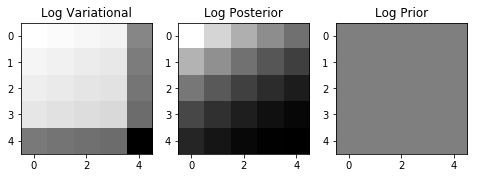

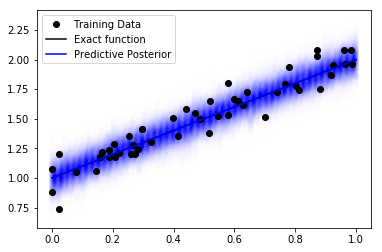

In [2]:
np.random.seed(5)
tf.set_random_seed(5)

# create a fake dataset from a 1D linear model with a bias term and corrupt with
#   independent Gaussian noise
n = 50
noise_variance = 0.01
x = np.random.rand(n,1);
Phi = np.hstack((x, np.ones(x.shape)))
xx = np.linspace(0,1,num=50).reshape((-1,1))
Phi_X = np.hstack((xx, np.ones(xx.shape)))
w_exact = np.array([[1., 1.]]).T
y = Phi.dot(w_exact)
y += np.random.normal(size=(n,1), scale=np.sqrt(noise_variance)) # add some noise

# initialize the W grid of discrete values the latent variables can take, 
#   and the prior / variational distibution
b = Phi.shape[1]
Wbar = np.tile([-1.,-0.5,0.,0.5,1.], (b,1)) # use same discrete values for all variables
mbar = Wbar.shape[1]
logP = np.zeros((b, mbar)) # uniform prior for weights

with tf.Session() as sess:
    # initialize the DIRECT model
    m = direct.BayesGLM(Phi=Phi, sig2_grid=np.atleast_1d(noise_variance), y=y, Wbar=Wbar, 
                        logP=logP, logpsig=np.zeros(1))
    sess.run(tf.global_variables_initializer())
    trace = m.train(n_epochs=1000, sess=sess, display_step=5)
    Q = sess.run(tf.exp(m.logQ))
    P = sess.run(tf.exp(m.logP))
    y_mean = sess.run(m.predict_mean(Phi_X=Phi_X))
    y_samples, sig2_samples = sess.run(m.predict_samples(Phi_X=Phi_X, n_samples=100))

# compute the exact posterior for comparison with the learned variational distribution
W = KhatriRaoMeshgrid(Wbar).expand()
# compute the exact log-likelihood
logl_exact = np.zeros((W.shape[1],1))
for i,w in enumerate(W.T): # loop through each possible set of parameters
    logl_exact[i] = -np.sum(np.power(y-Phi.dot(w.reshape((-1,1))), 2))/(2.*noise_variance) \
        - n*np.log(noise_variance)/2
# compute the exact parameter posterior
prior_expanded = KronMatrix(np.expand_dims(P, axis=2)).expand()
log_posterior = log_softmax(logl_exact + prior_expanded, axis=0).reshape((mbar,)*m.b, 
                                                                         order='F')
# get the prior and the variational dist
log_prior = prior_expanded.reshape((mbar,)*m.b, order='F')
log_variational = np.log(KronMatrix(np.expand_dims(Q,axis=2)).expand()
                        ).reshape((mbar,)*m.b, order='F')
# get the min and max values of everything so that I can plot it all on the same scale
vmin = np.min(np.hstack((log_posterior, log_prior, log_variational)))
vmax = np.max(np.hstack((log_posterior, log_prior, log_variational)))

# plot the posterior distribution of the latent variables
fig, ax_arr = plt.subplots(ncols=3, figsize=(8,4))
ax_arr[0].imshow(log_variational, interpolation='None', cmap='gray_r')#, vmin=vmin, vmax=vmax)
ax_arr[0].set_title('Log Variational')
ax_arr[1].imshow(log_posterior, interpolation='None', cmap='gray_r')#, vmin=vmin, vmax=vmax)
ax_arr[1].set_title('Log Posterior')
ax_arr[2].imshow(log_prior, interpolation='None', cmap='gray_r', vmin=log_prior.min()-0.1, 
                 vmax=log_prior.max()+0.1)
ax_arr[2].set_title('Log Prior');

# plot the predictive posterior mean
fig, ax = plt.subplots()
for i, sig2 in enumerate(sig2_samples.squeeze()): # loop through each predictive posterior sample 
    ax.plot(xx, y_samples[:,(i,)] + np.random.normal(size=(xx.shape[0],5), scale=np.sqrt(sig2)), 
            'b', alpha=0.002, lw=5) # plot the sample with Gaussian noise
# ax.plot(x_test, y_samples, 'b', alpha=0.1, lw=1)
ax.plot(x,y,'ko', label='Training Data')
ax.plot(xx, Phi_X.dot(w_exact), 'k', label='Exact function')
ax.plot(xx, y_mean, 'b', label='Predictive Posterior')
ax.legend(loc=0);

# Non-Linear Mean-Field Model
Now we'll consider a non-linear DIRECT generalized linear model with many basis functions (many discrete latent variables).
Specifically, we will consider $b=100$ basis functions and each latent variables will be able to take $\bar{m} = 15$ values so that posterior samples can be expressed as a vector of extremely low-precision 4-bit quantized integers.
In this case, computing the exact posterior is intractable, since it would require evaluating the model likelihood at $\bar{m}^b = 15^{100} \approx 10^{117}$ which is far greater than the number of atoms in the universe!
However, using the DIRECT method we can train this model extremely quickly.

The basis functions we will use are random Fourier features of a squared exponential kernel.
We will also specify $\bar{m} = 15$ discrete values of independent Gaussian noise variance.

Looking at the plot of the predictive posterior, its evident that the model fits the data well, however, the posterior distribution isn't so great as we move away from the data.
In the next section we can consider a more flexible mixture posterior distribution that we'll see will give a better predictive posterior.

[ 17:15:49 ] direct.misc INFO: initializing RBF random fourier features
[ 17:15:49 ] direct.models INFO: Inititializing model
[ 17:15:49 ] direct.models INFO: Beginnning training iterations. n_epochs=2000
[ 17:15:49 ] direct.models INFO: using L-BFGS-B optimizer
Epoch: 0001, ELBO: -119322.22, Time elapsed: 0.07997 seconds.
Epoch: 0250, ELBO: -86.196281, Time elapsed: 0.333 seconds.
Epoch: 0500, ELBO: -86.18933, Time elapsed: 0.6775 seconds.
Epoch: 0750, ELBO: -86.188346, Time elapsed: 1.036 seconds.
Epoch: 1000, ELBO: -86.187617, Time elapsed: 1.382 seconds.
Epoch: 1250, ELBO: -86.187286, Time elapsed: 1.662 seconds.
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.187266
  Number of iterations: 1210
  Number of functions evaluations: 1281
[ 17:15:51 ] tensorflow INFO: Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.187266


Text(0.5,1,'DIRECT Mean-Field Model')

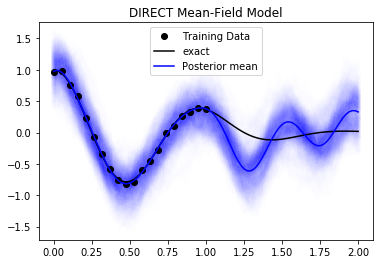

In [3]:
np.random.seed(5)
tf.set_random_seed(5)

# generate a non-linear toy dataset
test_fun = lambda x: np.cos(x*2.*np.pi)*np.exp(-np.square(x))
n = 20
x = np.linspace(0,1,num=n).reshape((-1,1))
x_test = np.linspace(0,2,num=100).reshape((-1,1))
y = test_fun(x) + 0.1*(np.random.rand(*x.shape)-0.5)
y_test = test_fun(x_test)

with tf.Session() as sess:
    # get the basis functions (features)
    kern = RBF_RFFs(1, n_rffs=50, log_lengthscale=np.log(0.1)) # num basis functions is 2*n_rffs
    sess.run(tf.global_variables_initializer())
    Phi = sess.run(kern.Phi(x))
    Phi_test = sess.run(kern.Phi(x_test))
    
    # initialize the DIRECT model
    mbar = 15
    Wbar = np.tile(np.linspace(-1, 1, num=mbar), (kern.n_features,1))
    noise_grid = np.logspace(-5,-2, num=15)
    logP = np.zeros((kern.n_features, mbar)) # uniform prior
    logpsig = np.zeros(noise_grid.shape) # uniform prior
    m = direct.BayesGLM(Phi=Phi, sig2_grid=noise_grid, y=y, Wbar=Wbar, logP=logP, logpsig=logpsig)
    
    # train the model and get the posterior mean and samples on the test set
    sess.run(tf.global_variables_initializer())
    m.train(n_epochs=2000, sess=sess, display_step=250)
    y_mean = sess.run(m.predict_mean(Phi_X=Phi_test))
    y_samples, sig2_samples = sess.run(m.predict_samples(Phi_X=Phi_test, n_samples=100))
    
# now plot the predictive posterior
fig, ax = plt.subplots()
for i, sig2 in enumerate(sig2_samples.squeeze()): # loop through each predictive posterior sample 
    ax.plot(x_test, 
            y_samples[:,(i,)] + np.random.normal(size=(x_test.shape[0],5), scale=np.sqrt(sig2)), 
            'b', alpha=0.002, lw=5) # plot the sample with Gaussian noise
# ax.plot(x_test, y_samples, 'b', alpha=0.1, lw=1)
ax.plot(x,y,'ko', label='Training Data')
ax.plot(x_test, y_test, 'k', label='exact')
ax.plot(x_test, y_mean, 'b', label='Posterior mean')
ax.legend(loc=0)
ax.set_title("DIRECT Mean-Field Model")

# Non-Linear Mixture Model
We can now consider a mixture variational distribution that does not factorize.
We will use 5 mixture components.
In this case, the variational entropy term of the ELBO cannot be exactly computed in an efficient manner using the DIRECT technique.
Instead we have two options:
* **Lower bound the entropy:** In this case, our gradients are still deterministic, allowing us to leverage quasi-Newton opimization methods for super-linear convergence. Unfortunately, our ELBO gradient estimates will be biased so we are not guranteed to converge to a local optima of the ELBO.
* **Use stochastic estimates of the entropy gradient:** In this case, our gradient estimate of the entropy (and thus the ELBO) will be unbiased, however, this comes at the cost of introducing stochasticity into our optimization objective. Fortunately, our gradient estimate can be computed very cheaply so we can use many samples to decrease the gradient variance. The number of samples is specified through the `reinforce_entropy` arguement.

We will compare both of these techniques on our toy-dataset from above.

Looking at the first plot for the "biased" method where we lower bound the entropy, it's evident that the predictive posterior is more reasonable than that of the mean-field model, however, it is not as good as the distribution from the "unbiased" method.
While the unbiased method takes slightly longer to train due to its stochastic gradients, it is a more robust approach than the biased gradients.
Still, a mixture model with biased gradients often outperforms the mean-field model outlined in the previous section.

Training DIRECT with Biased ELBO Gradients
[ 17:15:53 ] direct.models INFO: Inititializing model
[ 17:15:53 ] direct.models INFO: Beginnning training iterations. n_epochs=20000
[ 17:15:53 ] direct.models INFO: using L-BFGS-B optimizer
Epoch: 0001, ELBO: -119384.92, Time elapsed: 0.2257 seconds.
Epoch: 1000, ELBO: -87.218393, Time elapsed: 4.069 seconds.
Epoch: 2000, ELBO: -86.867318, Time elapsed: 7.969 seconds.
Epoch: 3000, ELBO: -86.708825, Time elapsed: 11.89 seconds.
Epoch: 4000, ELBO: -86.593344, Time elapsed: 15.78 seconds.
Epoch: 5000, ELBO: -86.560857, Time elapsed: 19.66 seconds.
Epoch: 6000, ELBO: -86.541341, Time elapsed: 23.58 seconds.
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 86.532075
  Number of iterations: 6080
  Number of functions evaluations: 6728
[ 17:16:20 ] tensorflow INFO: Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objec

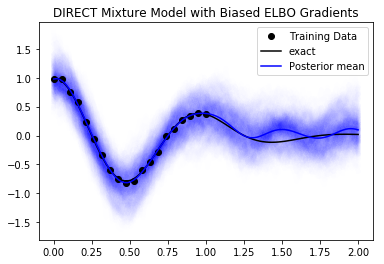

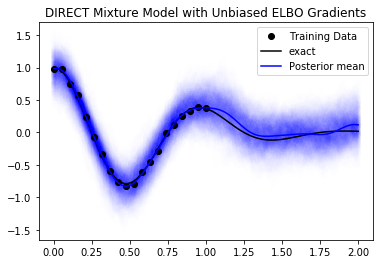

In [4]:
for unbiased_ELBO in [False, True]:
    print("Training DIRECT with %s ELBO Gradients"%(["Biased", "Unbiased"][unbiased_ELBO],))
    np.random.seed(5)
    tf.set_random_seed(5)
    with tf.Session() as sess:
        # initialize the DIRECT model
        m = direct.BayesGLM(Phi=Phi, sig2_grid=noise_grid, y=y, Wbar=Wbar, logP=logP, logpsig=logpsig,
                           n_mixtures=5, reinforce_entropy=(100*unbiased_ELBO))

        # train the model and get the posterior mean and samples on the test set
        sess.run(tf.global_variables_initializer())
        m.train(n_epochs=20000, sess=sess, display_step=1000)
        y_mean = sess.run(m.predict_mean(Phi_X=Phi_test))
        y_samples, sig2_samples = sess.run(m.predict_samples(Phi_X=Phi_test, n_samples=100))

    # now plot the predictive posterior
    fig, ax = plt.subplots()
    for i, sig2 in enumerate(sig2_samples.squeeze()): # loop through each predictive posterior sample 
        ax.plot(x_test, 
                y_samples[:,(i,)] + np.random.normal(size=(x_test.shape[0],5), scale=np.sqrt(sig2)), 
                'b', alpha=0.002, lw=5) # plot the sample with Gaussian noise
    # ax.plot(x_test, y_samples, 'b', alpha=0.1, lw=1)
    ax.plot(x,y,'ko', label='Training Data')
    ax.plot(x_test, y_test, 'k', label='exact')
    ax.plot(x_test, y_mean, 'b', label='Posterior mean')
    ax.legend(loc=0)
    ax.set_title("DIRECT Mixture Model with %s ELBO Gradients"%(["Biased", "Unbiased"][unbiased_ELBO],));

With respect to timing, bear in mind that the training time complexity is **independent** of the quantity of training data for all models presented.
This means that all of these models will run just as fast on a huge dataset!